# Машинное обучение, DS-поток, осень 2024
## Задание ML.13


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1 &mdash; **185 баллов**

Всего &mdash; **185 баллов**  

In [ ]:
# Bot check

# HW_ID: ds_ml13
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
import numpy as np
import os
import pandas as pd
import time
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import seaborn as sns
sns.set(palette='Set2')

import albumentations as A
from torchvision import transforms

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.detection.mean_ap import MeanAveragePrecision
device = "cuda" if torch.cuda.is_available() else "cpu"

**Перед вами последнее задание в этом семестре по нейронным сетям!** Хорошие новости: вам не придется возиться с данными, вся обработка вам дана. Более того, вам дан репозиторий с реализацией модели. Но задание немаленькое &mdash; нужно обучить модель на данных, реализовать визуализацию, подсчет метрики, потом немного изменить архитектуру и обучить модель еще раз. Будет интересно!

## Задача 1. Single Shot Multibox Detector (SSD)

Вам предстоит применить [реализацию SSD](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection) для [датасета с игральными картами](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10), а также исследовать некоторые свойства модели: проверить, как модель ведет себя на более мелких картинках и попробовать изменить модель так, чтобы качество стало лучше.

**Как оформить работу**  
Скорее всего вам будет удобнее работать с моделью через модули. В таком случае **все измененные используемые файлы отправляйте в бот** (в ноутбуке явно поясните, что вы изменяли и где). Иначе пишите измененные функции прямо в ноутбуке. В коде указывайте, где изменения, с помощью комментов.

---

#### 1. Данные



Скачаем данные с github.

In [ ]:
!git clone https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10.git
!cp -r "TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10/images" .
!rm -r "TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10"

В папке `images` содержатся папки с изображениями для обучения и тестирования: `train` и `test` соответственно. Также в `images` есть таблицы с классами и
координатами ограничивающих прямоугольников `train_labels.csv` и `test_labels.csv`. Рассмотрим одну из таблиц с разметкой.

In [ ]:
data = pd.read_csv("images/train_labels.csv")
data.head()

Сразу заметим, что картинки в датасете разного размера.

Определим функцию, которая по названию файла выдает лейбл и координаты боксов.

In [ ]:
def get_file_labels_boxes(data, file):
    """
    Функция, которая по названию файла выдает лейбл и координаты боксов.
    Аргументы:
      data -- датафрейм с данными;
      file -- название файла.
    Возвращает:
      labels и boxes -- лейблы классов и координаты боксов
      в формате xmin, ymin, xmax, ymax.
    """
    part_data = data.where(data["filename"] == file).dropna(how='any', axis=0)
    labels = [class2label[class_] for class_ in part_data["class"].values]
    boxes = part_data[["xmin", "ymin", "xmax", "ymax"]].values
    return labels, boxes

Всего в данных 6 классов карт. Добавим к ним класс фона `bg`. Он понадобится нам для работы с SSD.

In [ ]:
n_classes = 7
classes = ['bg', 'nine', 'ten', 'jack', 'queen', 'king', 'ace', 'bg',]
class2label = {'bg': 0, 'nine': 1, 'ten': 2, 'jack': 3, 'queen': 4, 'king': 5, 'ace': 6}

Посмотрим как выглядят наши данные в целом. Визуализируем картинки и соответствующие им боксы. Для этого будем использовать следующую функцию отрисовки. Вы можете далее изменять ее как вам будет удобнее.

In [ ]:
def plot_boxes(
    boxes, labels, classes, ax, edgecolor='red', scores=None, threshold=None
    ):
    """
    Функция отрисовки bounding box-ов в задаче детекции.
    Аргументы:
      boxes -- массив боксов, которые задаются координатами
      xmin, ymin, xmax, ymax;
      labels -- лейблы классов;
      scores -- уверенность модели в детекции боксов;
      threshold -- порог отсечения боксов по threshold;
      ax -- полотно, на котором отображена исходная картинка.
    """

    box_kwargs = dict(linewidth=2, fill=False, edgecolor=edgecolor, facecolor='none')
    bbox = dict(facecolor='white', alpha=0.5)
    annot_kwargs = dict(color='black', size=14, bbox=bbox)

    for i, box in enumerate(boxes):

        if (scores is not None) and (threshold is not None) and (scores[i] < threshold):
            continue

        left_x, top_y, right_x, bottom_y = box
        width = right_x - left_x + 1
        height = bottom_y - top_y + 1

        # Прямоугольная рамка
        box_patch = Rectangle((left_x, top_y), width=width, height=height, **box_kwargs)
        # Добавляем рамку к изображению
        ax.add_patch(box_patch)

        # Добавляем текст к фото справа сверху от рамки
        if scores is not None:
            ax.text(left_x, top_y, f"{classes[labels[i]]}, {scores[i]:.2f}", **annot_kwargs)
        else:
            ax.text(left_x, top_y, f"{classes[labels[i]]}", **annot_kwargs)

Визуализируем 20 картинок из тренировочных данных.

In [ ]:
files = os.listdir("images/train")

fig, axes = plt.subplots(4, 5, figsize=(16, 16))

# Итератор по изображениям
i = 0
# Итератор по файлам
j = 0
while i < 20:

    file = files[j]
    j += 1

    # Выбираем только картинки
    if file[-4:].lower() != ".jpg":
        continue
    img = Image.open(os.path.join("images/train", file))

    # Получаем лейблы и боксы, соотв. картинке
    labels, boxes = get_file_labels_boxes(data, file)

    # Визуализируем
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    plot_boxes(boxes, labels, classes, ax)
    ax.axis("off")

    i += 1

Для модели SSD300 нужны на вход картинки размера 300 x 300. Причем здесь нам не помогут разные трансформации из `torchvision.transforms`, так как нам нужно изменять еще и боксы. К нам в помощь приходит библиотека [Albumentations](https://albumentations.ai/docs/). Подробнее посмотреть как работать с библиотекой в случае детекции можно [тут](https://albumentations.ai/docs/examples/example_bboxes/).

Для того, чтобы обрезать картинки до квадрата так, чтобы карты точно там присутствовали, а потом ресайзнуть до размера 300 x 300, можно использовать следующую функцию. Можете также поэкспериментировать с Albumentations и сделать что-то более интересное.



In [ ]:
def spec_crop(image, boxes):
    """
    Функция, которая обрезает изображения до квадрата так,
    чтобы все боксы по возможности остались внутри квадрата.
    Полученные картинки приводятся к размеру 300x300.
    """

    # Вычисляем границы всех боксов вместе
    x_min = boxes[:, 0].min()
    y_min = boxes[:, 1].min()
    x_max = boxes[:, 2].max()
    y_max = boxes[:, 3].max()

    # Ширина и высота изображения
    h, w = image.size
    # Размер квадрата, до которого мы обрежем изображение
    size = min(h, w)
    half_size = size // 2

    # x-координата центра прямоугольника, ограничивающего все боксы
    x_ctr = (x_max - x_min) // 2 + x_min
    # По ней мы вычисляем x_min и x-max -- координаты квадрата,
    # который мы вырежем из исходного изображения,
    # чтобы получить квадратное изображение.
    if x_ctr < half_size:
        x_min = 0
        x_max = size - 1
    elif x_ctr + half_size >= h:
        x_max = h - 1
        x_min = x_max - size + 1
    else:
        x_min = x_ctr - half_size
        x_max = int(x_min + size) - 1

    # y-координата центра прямоугольника, ограничивающего все боксы
    y_ctr = (y_max - y_min) // 2 + y_min
    # По ней мы вычисляем y_min и y-max -- координаты квадрата,
    # который мы вырежем из исходного изображения,
    # чтобы получить квадратное изображение.
    if y_ctr < half_size:
        y_min = 0
        y_max = size - 1
    elif y_ctr + half_size >= w:
        y_max = w - 1
        y_min = y_max - size + 1
    else:
        y_min = y_ctr - half_size
        y_max = int(y_min + size) - 1

    # Приводим все координаты к int
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    # Обрезаем изображение до квадрата и изменяем размер, полученного изображения
    transform = A.Compose([
        A.Crop(x_min, y_min, x_max, y_max),
        A.Resize(300, 300),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )
    transformed = transform(image=np.array(image), bboxes=boxes, labels=labels)
    image, boxes = transformed["image"], transformed["bboxes"]

    return image, boxes

Допустим, мы ограничились выше функцией `spec_crop`. Положим все обрезанные картинки в новую папку cropped_images.



In [ ]:
def change_file_boxes(data, file, boxes):
    """Функция, которая изменяет координаты боксов."""
    data.loc[data["filename"] == file, ["xmin", "ymin", "xmax", "ymax"]] = boxes


dir = "images"
res_dir = "cropped_images"
os.makedirs(res_dir, exist_ok=True)

for part in ["train", "test"]:
    # Создаем папку, если ее нет
    os.makedirs(os.path.join(res_dir, part), exist_ok=True)

    # Названия файлов с картинками и таблица с разметкой
    files = os.listdir(os.path.join(dir, part))
    data = pd.read_csv(os.path.join(dir, f"{part}_labels.csv"))
    data[["xmin", "ymin", "xmax", "ymax"]] = data[["xmin", "ymin", "xmax", "ymax"]].astype(float)

    for file in files:

        # Выбираем только картинки
        if file[-4:].lower() != ".jpg":
            continue
        image = Image.open(os.path.join(dir, part, file))

        # Получаем лейблы и координаты боксов
        labels, boxes = get_file_labels_boxes(data, file)

        # Обрезаем картинку
        image, boxes = spec_crop(image, boxes)

        # Сохраняем результат обрезки
        plt.imsave(os.path.join(res_dir, part, file), image)
        change_file_boxes(data, file, boxes)

    data.to_csv(os.path.join(res_dir, f"{part}_labels.csv"))

Предлагаем вам класс датасета, который будет хранить все картинки, боксы и лейблы в памяти. К счастью, их немного, зато такой подход будет быстрее работать. В данном случае скорость критична, в виду долгой работы сети в целом.

In [ ]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


class PlayingCardsDataset(Dataset):
    def __init__(self, images_path, data_path, input_size=(160, 240)):
        """
        Класс-датасет для задачи детекции игральных карт.
        """

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # Решайте сами, когда и зачем вам нужан нормализация
            transforms.Normalize(mean=MEAN, std=STD)])

        images, boxes, labels = self._read_images_boxes_labels(images_path, data_path)
        self.images = images
        self.boxes = boxes
        self.labels = labels


    def _read_images_boxes_labels(self, images_path, data_path):
        """
        Загружаем все изображения, а также соотвествующие им боксы и лейблы.
        """
        data = pd.read_csv(data_path)

        images = []
        boxes = []
        labels = []

        for file in os.listdir(images_path):
            image =  self.transform(Image.open(os.path.join(images_path, file)))
            labels_, boxes_ = get_file_labels_boxes(data, file)
            images.append(image)
            labels.append(torch.tensor(labels_))
            # Все координаты боксов делим на 300,
            # потому что в SSD используются относительные координаты.
            boxes.append(torch.tensor(boxes_) / 300)

        return images, boxes, labels

    def __len__(self,):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.boxes[idx], self.labels[idx]

Но есть одна загвоздка, просто так такой датасет в даталоадер не положишь, потому что он будет пытаться стекать лейблы и боксы. Однако для каждой картинки у нас разное число объектов, поэтому стекать не получится. Для этого нужно определить collate функцию, которая будет определять, как даталоадеру объединять данные в батч.

In [ ]:
def collate_fn(batch):
    """
    Эта функция поясняет как комбинировать данные в батч.
    Для этого мы будем использовать списки.
    Аргумент:
      batch: итерируемый объект из __getitem__()
    Возвращает:
      тензор картинок
    """

    images = []
    boxes = []
    labels = []

    for b in batch:
        images.append(b[0])
        boxes.append(b[1])
        labels.append(b[2])

    images = torch.stack(images)

    return images, boxes, labels

Таким образом мы можем получить даталоадер для обучающих данных.

In [ ]:
batch_size = 16
train_dataset = PlayingCardsDataset(
    images_path="cropped_images/train",
    data_path="cropped_images/train_labels.csv"
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=collate_fn)

Для тестовых данным нам хватит датасета.

In [ ]:
test_dataset = PlayingCardsDataset(
    images_path="cropped_images/test",
    data_path="cropped_images/test_labels.csv"
)

#### 2. Обучение SSD300 (50 баллов)
- Обучите SSD300 на датасете с игральными картами.
- Визуализируйте график лосса при обучении.

Для того, чтобы не тратить много времени, рассмотрите код функций обучения из `utils.py`. Некоторые из них можно поменять для удобства использования.

In [ ]:
# Клонируем репозиторий
! git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection.git
# Копируем все из папки a-PyTorch-Tutorial-to-Object-Detection в текущую папку
! cp a-PyTorch-Tutorial-to-Object-Detection/* . -R -n -v
# Удаляем ненужные папки
! rm -r "a-PyTorch-Tutorial-to-Object-Detection"
! rm -r img
from model import *

In [ ]:
def train():


#### 3. Инференс и визуализация. (45 баллов)
- Визуализируйте результаты детекции на тестовых данных. Не забудьте, что координаты боксов на выходе будут от 0 до 1. Их нужно умножить на 300.

In [ ]:
def plot_predictions(dataset, model, classes, ...):
    '''Строит предсказания model для нескольких картинок из dataset
    * classes -- метки классов'''

    # <YOUR CODE HERE>

In [ ]:
plot_predictions(test_dataset, model, classes)

- Посчитайте mAP, пример см. в семинаре.

In [ ]:
def get_mAP(dataset, model, ...):
    '''Подсчитывает статистики Mean Average Precision для model на dataset'''

    # <YOUR CODE HERE>
    return ...

In [ ]:
get_mAP(test_dataset, model)

- Посчитайте и визуализируйте матрицу ошибок (Confusion Matrix) на тестовых данных. Для подсчета матрицы используйте [реализацию CM из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), для визуализации &mdash; [heatmap из seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [ ]:
def get_confusion_matrix(dataset, model, iou_threshold=0.5, matrix_labels=list(range(8)),
                         top_k=50, min_score=0.5, max_overlap=0.5):
    """
    Получает confusion matrix.

    * dataset -- датасет, для которого считается матрица.
    * model -- обученная модель.
    * iou_threshold -- порог, по которому выделяются предсказанные объекты для реальных.
    * min_score -- минимальный порог, когда бокс считается принадлежащим одному из классов.
    * max_overlap -- максимальный размер перекрытия, используемый при подавлении немаксимумов.
    * top_k -- максимальное количество предсказаний, которые мы оставляем.

    :return cm -- confusion matrix.
    """

    # <YOUR CODE HERE>
    return cm

def plot_confusion_matrix(
    dataset, model, display_labels,
    iou_threshold=0.5, matrix_labels=list(range(1, 8)),
    top_k=50, min_score=0.5, max_overlap=0.5
):
    """
    Визуализирует confusion matrix.

    * dataset -- датасет, для которого считается матрица.
    * model -- обученная модель.
    :display_labels -- лейблы, которые будут отображены в матрице.
    """

    # <YOUR CODE HERE>

In [ ]:
plot_confusion_matrix(test_dataset, model, display_labels=classes[1:])

**Вывод:**

...

#### 4. Маленькие карты

Уменьшим карты на картинках. Для этого будем случайно собирать 4 изображения из датасета и соединять их в коллаж, тем самым получая изображение с более мелкими объектами. Можно использовать и другие способы уменьшения, но данный способ, на взгляд автора, дает более реалистичные изображения и не очень трудозатратный.

In [ ]:
def get_smaller_images(images, old_boxes):
    """
    Уменьшает изображения и соотвествующие ему боксы.
 
    :param images -- изображения, их должно быть 4
    :param boxes -- боксы, соотвествующие каждому изображению
    """
    image = torch.zeros((3, 300, 300))
    boxes = []
 
    transform = transforms.Resize((150, 150))
    for i, j in zip([0, 0, 1, 1], [0, 1, 0, 1]):
        image[:, 150 * i: 150 * (i + 1), 150 * j: 150 * (j + 1)] = transform(images[i * 2 + j])
        for box in old_boxes[i * 2 + j]:
            x_min, y_min, x_max, y_max = box * 0.5
            x_min += j * 0.5
            x_max += j * 0.5
            y_min += i * 0.5
            y_max += i * 0.5
            boxes.append([x_min, y_min, x_max, y_max])
 
    return image, boxes

Создадим целую папку с изображениями, уменьшенными выше описанным способом.

In [ ]:
# Создаем папку, если ее нет
os.makedirs(res_dir, exist_ok=True)
 
totensor = transforms.ToTensor()
 
for part in ["train", "test"]:
    # Создаем папку, если ее нет
    os.makedirs(os.path.join(res_dir, part), exist_ok=True)
 
    # Названия файлов с картинками и таблица с разметкой
    files = os.listdir(os.path.join(dir, part))
    data = pd.read_csv(os.path.join(dir, f"{part}_labels.csv"))
    new_data = pd.DataFrame(columns=['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
    print(f"Количество изображений в исходных {part} данных: {len(files)}")
 
    if part == "train":
        num_images = 300
    else:
        num_images = 70
 
    for i in range(300):
 
        # Собираем 4 изображения
        n = 0
        images, all_boxes, all_labels = [], [], []
        while n < 4:
            file = np.random.choice(files)
            if file[-4:].lower() != ".jpg":
                continue
            
            image = totensor(Image.open(os.path.join(dir, part, file)))
            labels, boxes = get_file_labels_boxes(data, file)
            images.append(image)
            # Переводим боксы в относительную шкалу
            boxes /= 300
            all_boxes.append(boxes)
            all_labels.extend(labels)
            n += 1
        
        # Собираем одну картинку из несокльких маленьких
        image, boxes = get_smaller_images(images, all_boxes)
        boxes = [[float(c) * 300 for c in box] for box in boxes]
 
        # Сохраняем результат
        filename = f'image{i}.jpg'
        plt.imsave(os.path.join(res_dir, part, filename), image.permute(1, 2, 0).numpy())
 
        for box, label in zip(boxes, all_labels):
            new_data = new_data.append({'filename': filename, 'class': classes[label],
                            'xmin': box[0], 'ymin': box[1], 'xmax': box[2], 'ymax': box[3],},
                            ignore_index=True)
            
    new_data.to_csv(os.path.join(res_dir, f"{part}_labels.csv"))

Посмотрим, что получилось.

In [ ]:
files = os.listdir("small_images/train")
data = pd.read_csv("small_images/train_labels.csv")

fig, axes = plt.subplots(4, 5, figsize=(20,20))

# Итератор по изображениям
i = 0
# Итератор по файлам
j = 0
while i < 20:

    file = files[j]
    j += 1

    # Выбираем только картинки
    if file[-4:].lower() != ".jpg":
        continue
    img = Image.open(os.path.join("small_images/train", file))

    # Получаем лейблы и боксы, соотв. картинке
    labels, boxes = get_file_labels_boxes(data, file)

    # Визуализируем
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    plot_boxes(boxes, labels, classes, ax)
    ax.axis("off")

    i += 1

#### 5. Тестирование SSD на маленьких картах (10 баллов)

На новом теством датасете с маленькими картами:
- визуализируйте предсказания обученной модели
- посчитайте mAP
- визуализируйте Confusion Matrix

**Вывод**

...

#### 6. Улучшение качества распознавания для более мелких объектов (65 баллов)

Смешаем обычные картинки и наши уменьшенные. Будем использовать такую смесь для дообучения модели.

In [ ]:
! mkdir normal_and_small_images normal_and_small_images/train
! cp cropped_images/train/* normal_and_small_images/train -R -n -v
! cp small_images/train/* normal_and_small_images/train -R -n -v

In [ ]:
data = pd.read_csv('cropped_images/train_labels.csv', index_col=0)[['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']]
data = pd.concat([data, pd.read_csv('small_images/train_labels.csv', index_col=0)])
data.to_csv("normal_and_small_images/train_labels.csv")

In [ ]:
train_batch_size = 16
train_dataset = PlayingCardsDataset(
    images_path="normal_and_small_images/train",
    data_path="normal_and_small_images/train_labels.csv"
)
train_dataloader = DataLoader(
  train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True, collate_fn=collate_fn)

Из feature map $FM\ 7$ размера 19x19(x1024) с помощью ряда сверток получим набор дополнительных feature map $FM\ 8_2$, $FM\ 9_2$, $FM\ 10_2$, $FM\ 11_2$ разных размеров: 10x10(x512), 5x5(x256), 3x3(x256) и 1x1(x256). Этот ряд сверток состоит из блоков сверток из 2 слоев каждый. Понижение размерности в здесь достигается путем применения stride = 2.  

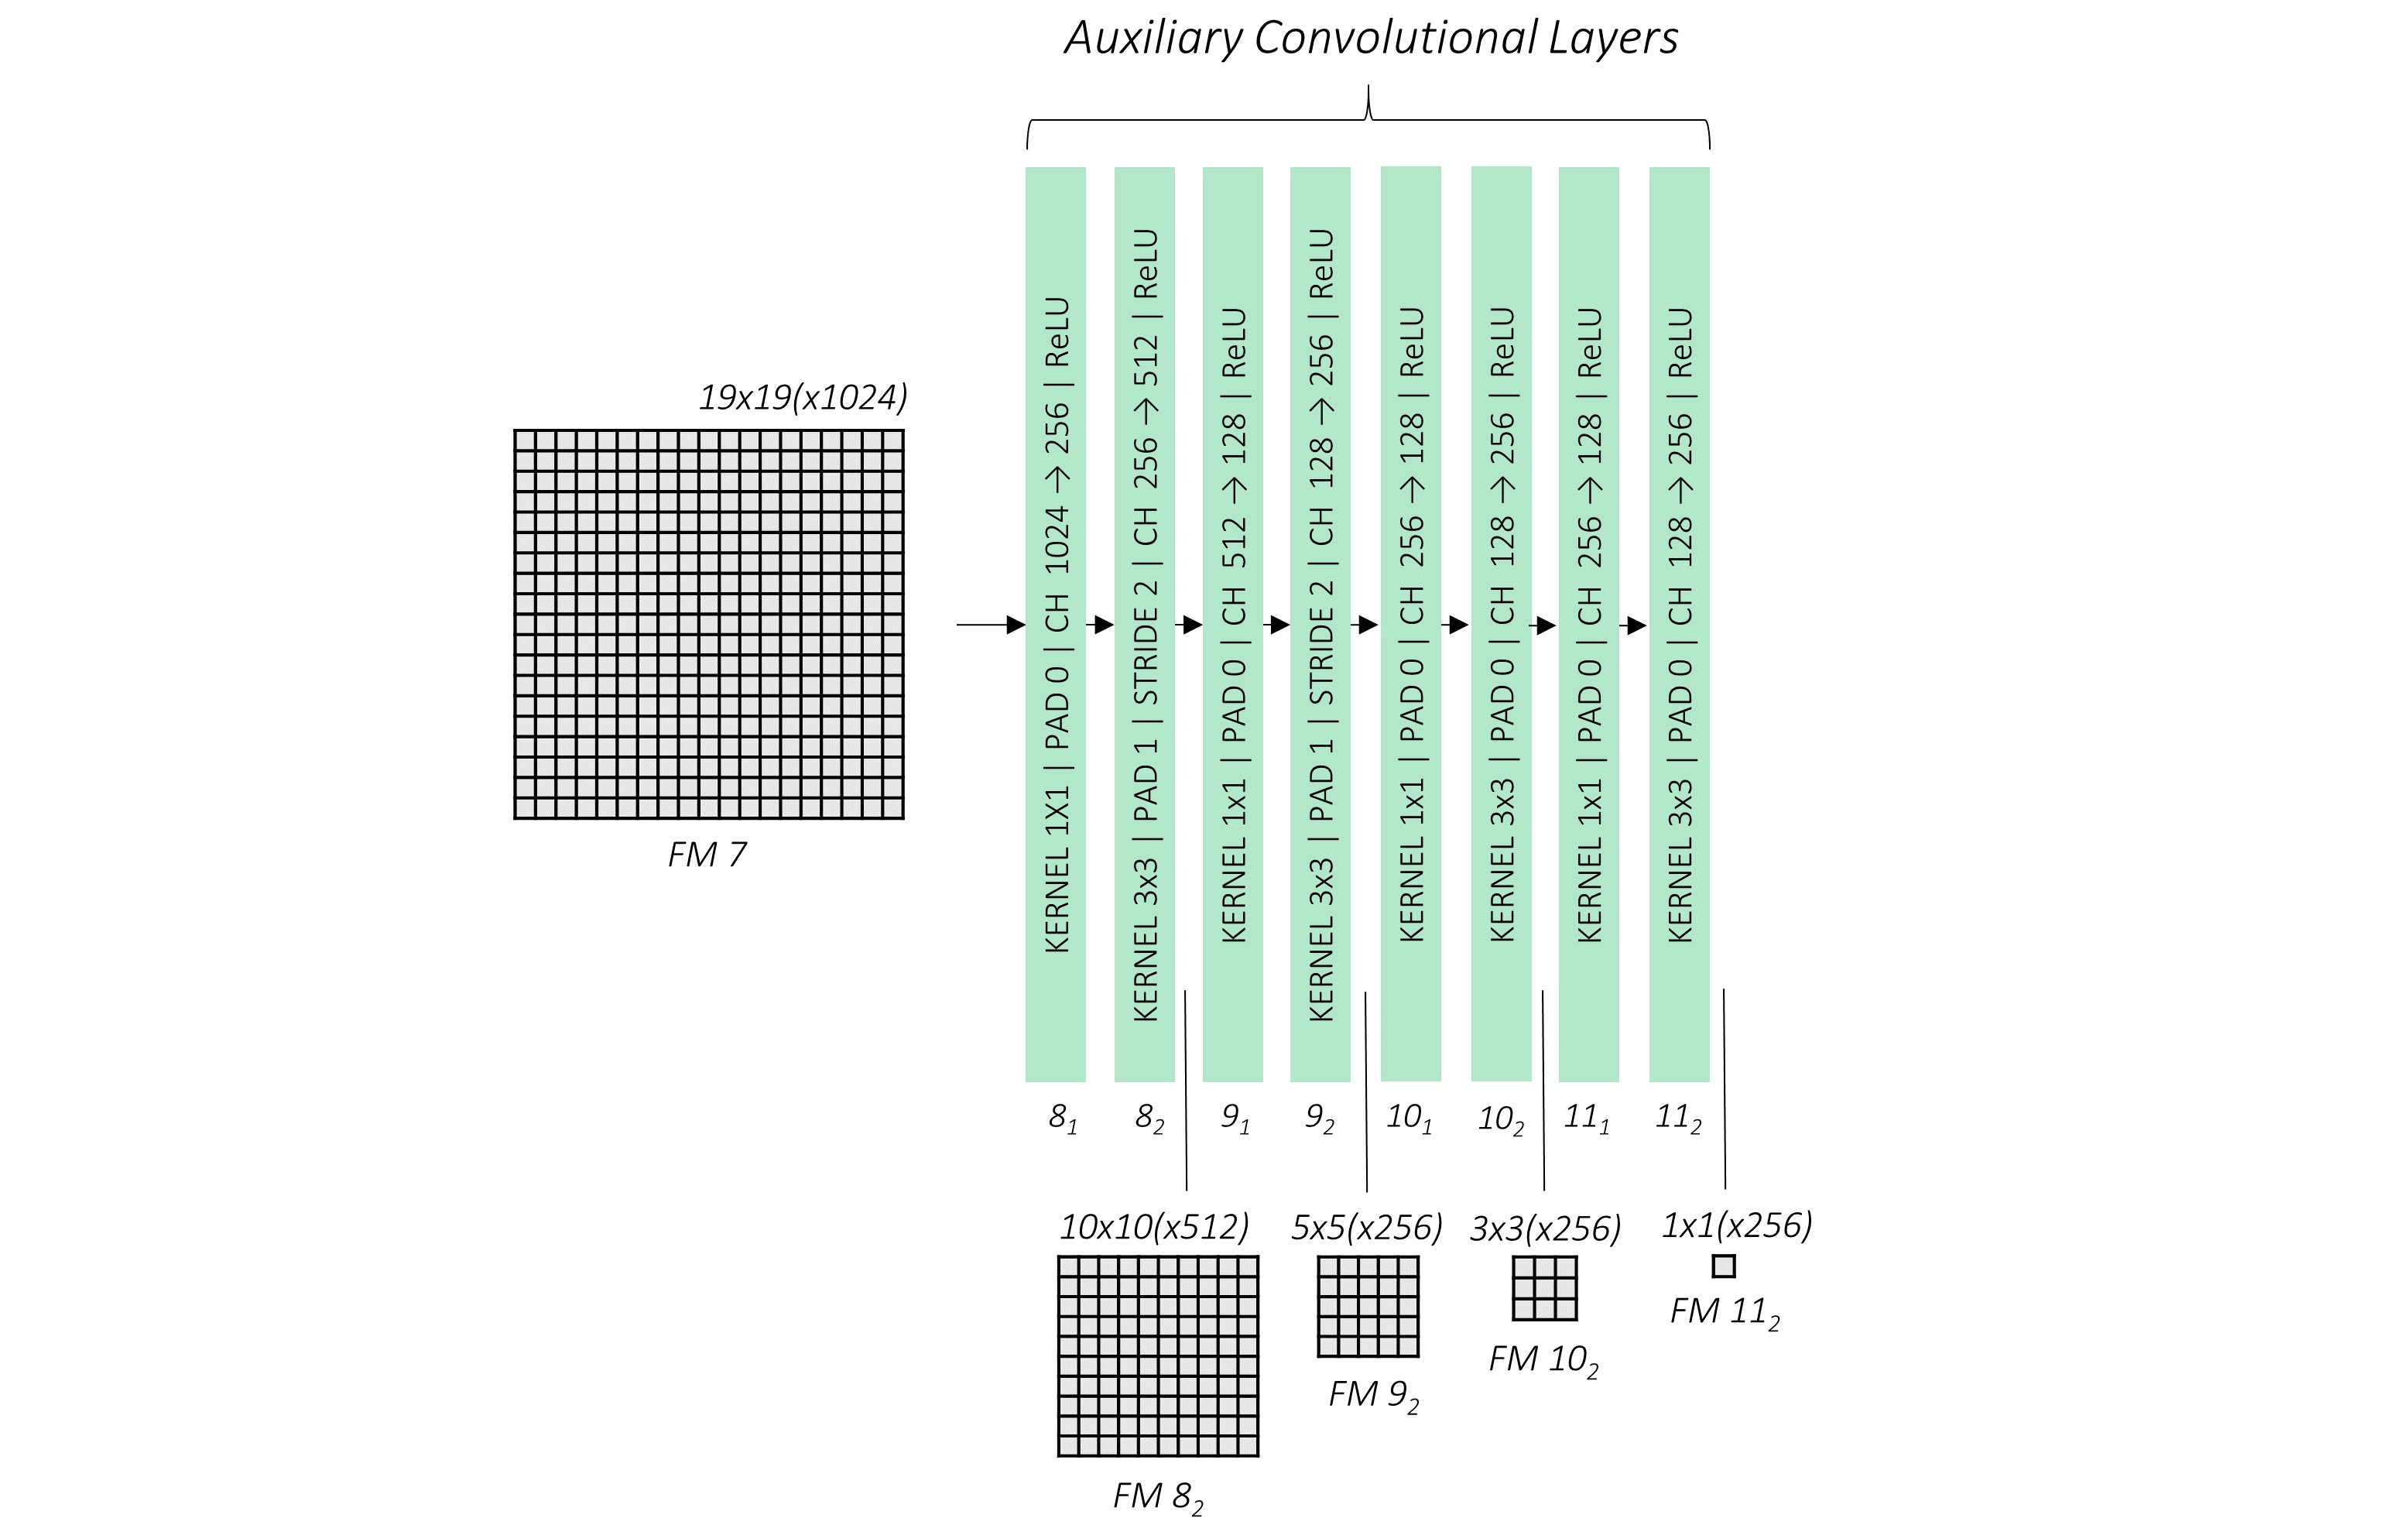

* Измените архитектуру модели. Добавьте обратные свертки после последнего слоя `conv_11_2` в классе `AuxiliaryConvolutions`. Выходы полученных сверток нужно сделать такого же размера как feature-map-ы. Объедините их с соответствующими feature-map-ами, а результат объединения прогоните через слой conv с ядром 1x1, для каждого объединения отдельно. На выходе должны получиться новые feature-map-ы такого же размера как и до изменения архитектуры. На картинке &mdash; возможный вариант такой модификации:


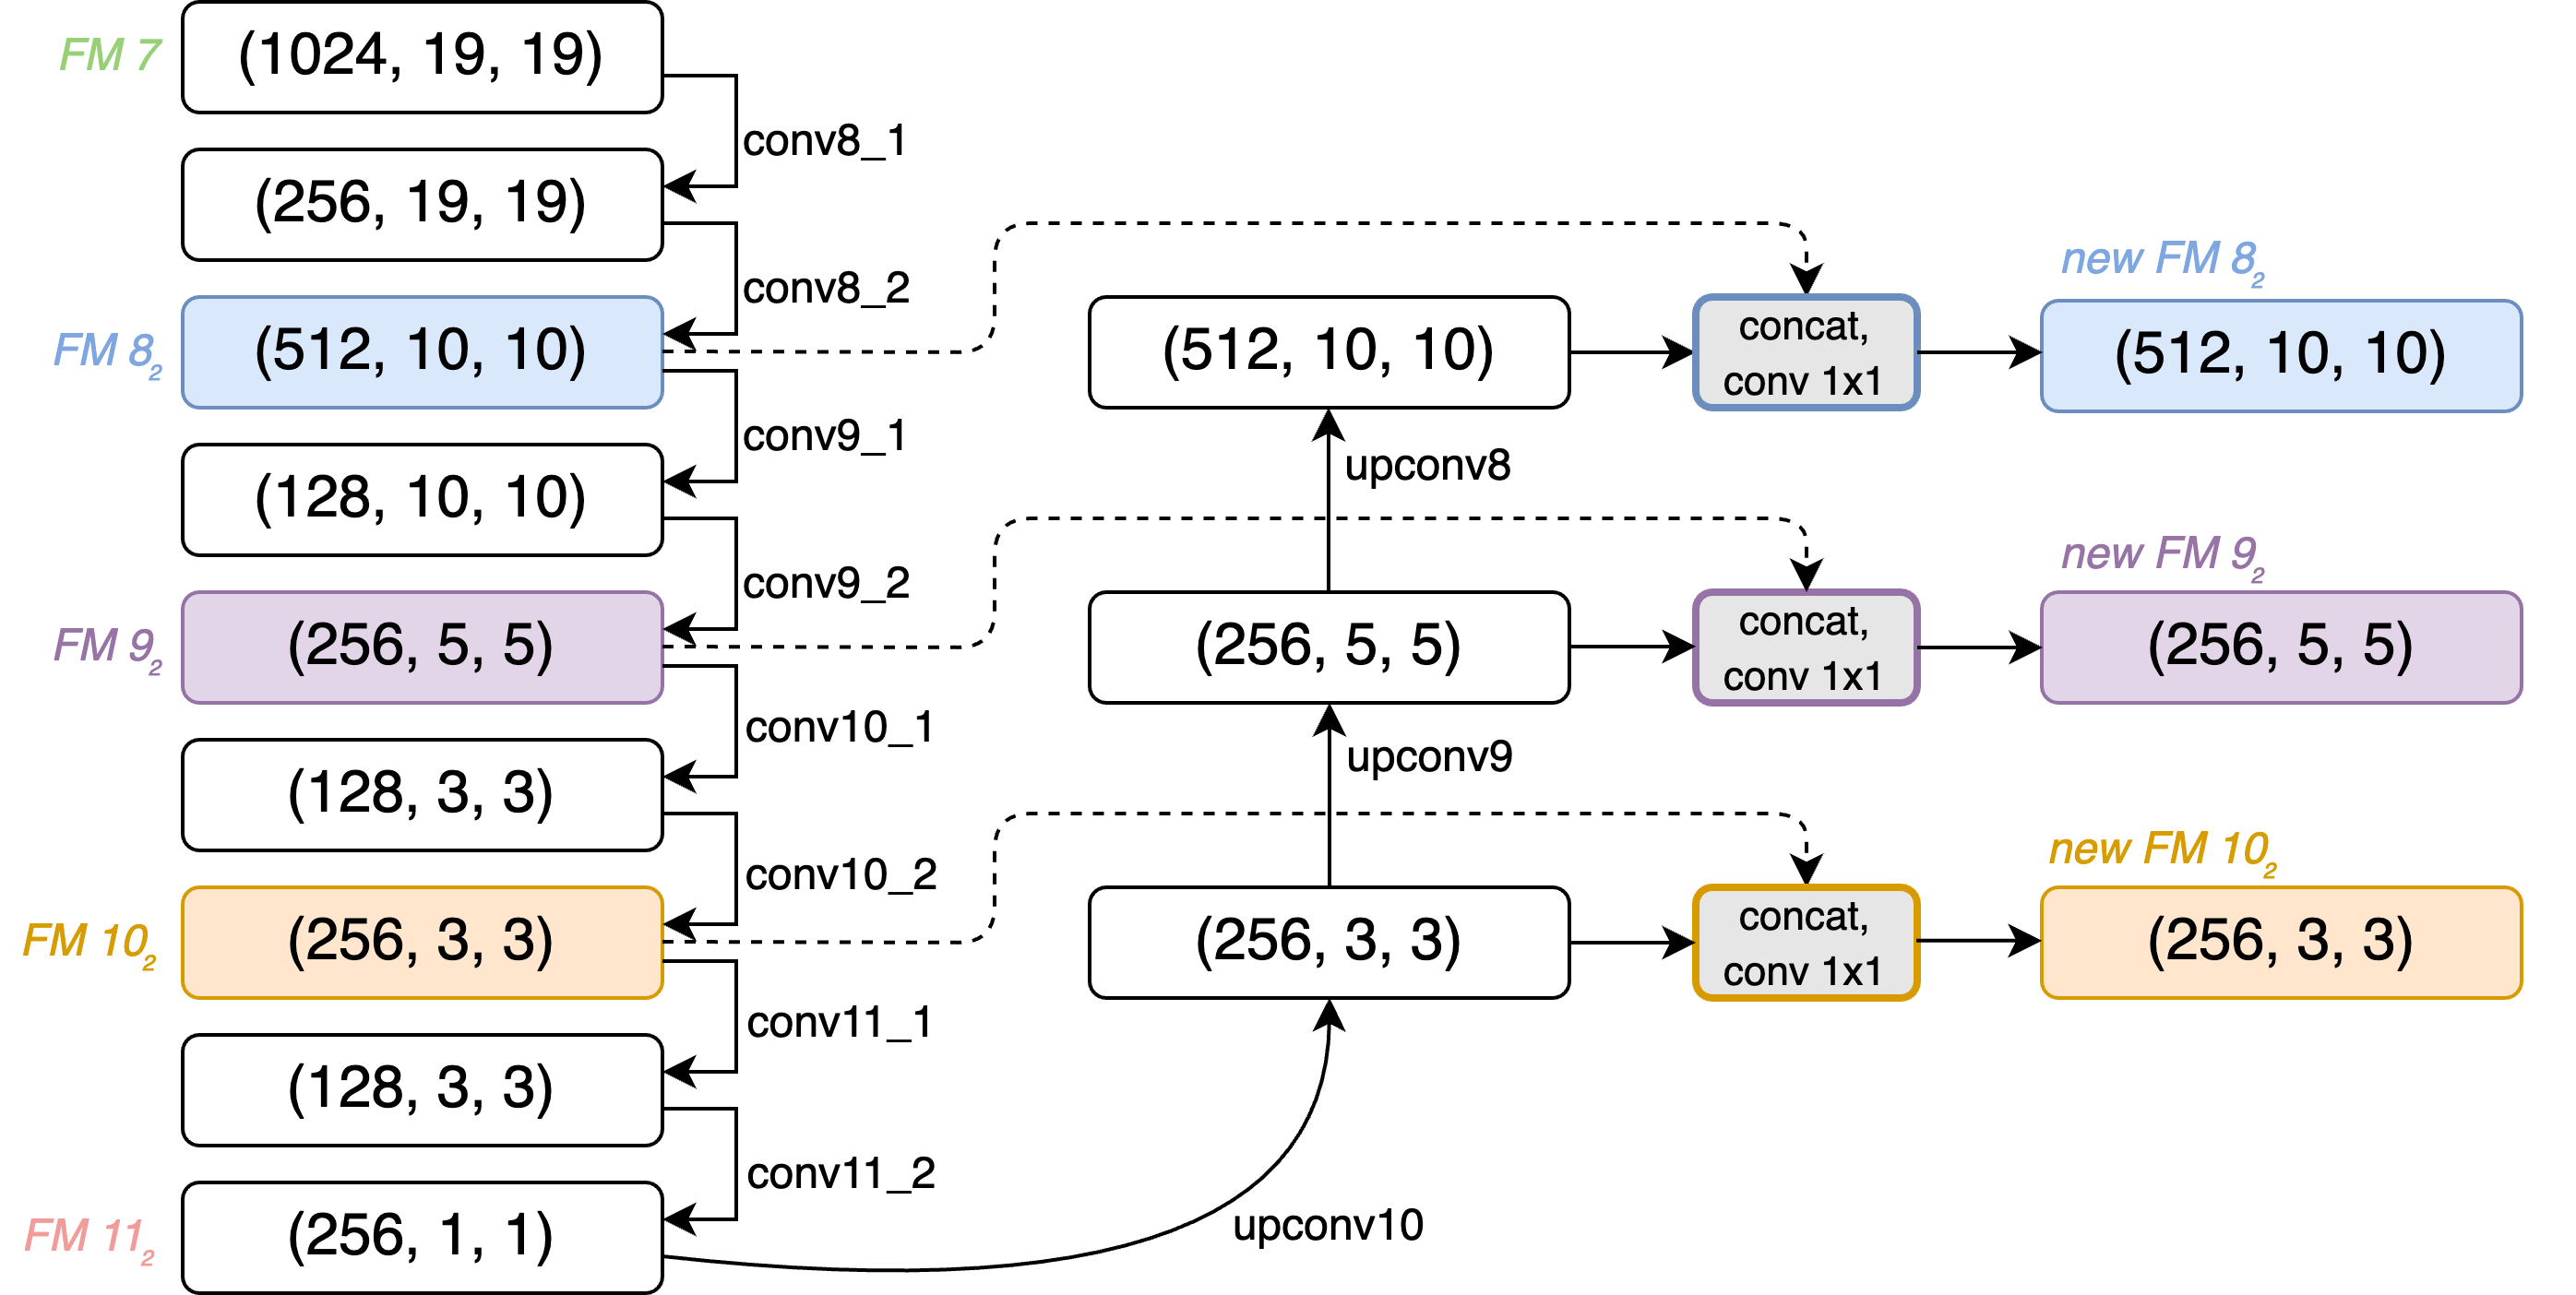

Не забудьте пояснять, где и что вы изменили, если делаете изменения в .py файле и потом импортируете.

* Обучите модель с измененной архитектурой, постройте график лосса.

* Проверьте, улучшилось ли качество при использовании такой модели (визуализация предсказаний, mAP, Confusion Matrix).

**Вывод**  

...

#### 7. Применение модели в реальной жизни (10 баллов)
Примените лучшую модель к своим фото карт, главное, не берите фото из тренировочных и тестовых данных. Оцените качество визуально.

Вывод:

...

#### 8. Вывод по всей задаче (5 баллов)

...